## Install Dependencies


### torch, torchvision

In [1]:
# install torch and torchvision
!pip3 install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


### pytorch3d

In [2]:
import os
import torch

try:
    import pytorch3d
except ModuleNotFoundError:
    !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    !tar xzf 1.10.0.tar.gz
    os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    !pip install git+https://github.com/facebookresearch/pytorch3d.git

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   987k      0 --:--:-- --:--:-- --:--:-- 3066k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-z950vzpt
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-z950vzpt
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 42 kB 780 kB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.7.2-cp38-cp38-linux_x86_64.whl size=51548427 sha256=327f9eea9b61df554bbbc913191c609fffbb1c00af52390f6160dd9f8e8b3a54
  Stored in directory: /tmp/pip-ephem-wheel-cache-w1cntk4e/wheels/5e/a7/7c/814c3888eaaecaaf0f533faeb3c68

In [3]:
import pytorch3d
pytorch3d.__version__

'0.7.2'

### SMPL / Meshes

In [4]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.0 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58286 sha256=5eb0faf330a2df631aedc3efed12363cf838bda804cffbdcaee588df262e746b
  Stored in directory: /root/.cache/pip/wheels/d9/a2/b8/b8aeeeaeb01b5002085156add1aed832f2fb03e79d0f22dfed
Successfully built chumpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 27.5 MB/s 


### CLIP

In [5]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-j7jwmq0r
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-j7jwmq0r
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=7e82155965009f54fa1f077e346d5947631c9104bdfd6f03bda8749908658d88
  Stored in directory: /tmp/pip-ephem-wheel-cache-cmku9atu/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


## GPU

In [7]:
import torch

torch.cuda.is_available()

True

In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [9]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

## Setup

### Codebase Loading

In [10]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 916, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 916 (delta 165), reused 226 (delta 123), pack-reused 622
Receiving objects: 100% (916/916), 78.67 MiB | 38.69 MiB/s, done.
Resolving deltas: 100% (533/533), done.


### Local Imports 

In [11]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, OptimConfig, TrackerConfig, init_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

import numpy as np

from torch.nn.functional import cosine_similarity

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.8/dist-packages/smplpytorch/pytorch/smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


## Test: SMPL and Rendering

In [12]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(verts,faces):
  return txfactory.from_image(colored_reference_SMPL ,verts, faces)
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, batchsize=5, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
meshes = smpl_model.meshes(theta=pose_vect, beta=shape_vect)

In [13]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# cameras' spherical coordinates
radiuses = [2.25]*5
azimuths = (0, 45, 135, -45, -135)
elevations = [5]*5
coords = (radiuses, azimuths, elevations)
# create cameras using cameras factory
cameras = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(0.1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=cameras)
# render the textured meshes generated by SMPL
test_imgs_t = renderer.render(meshes)
# shape of the rendered images
test_imgs_t.shape

torch.Size([5, 244, 244, 4])

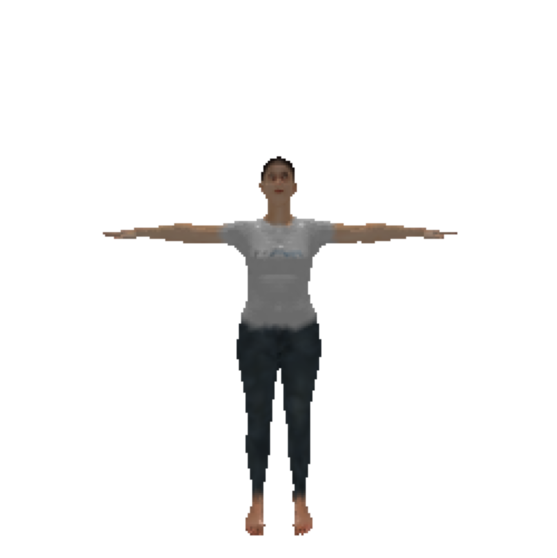

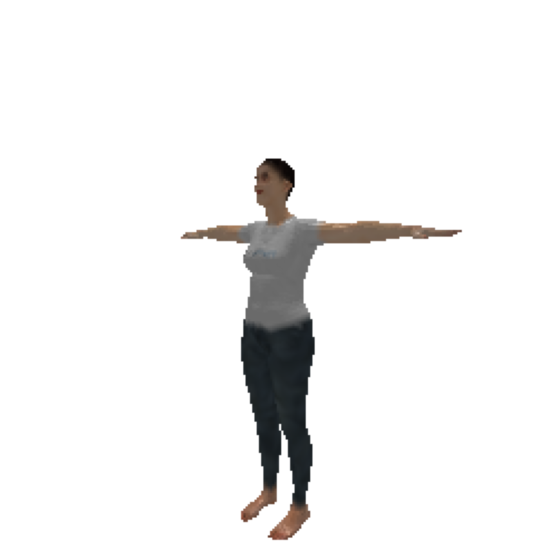

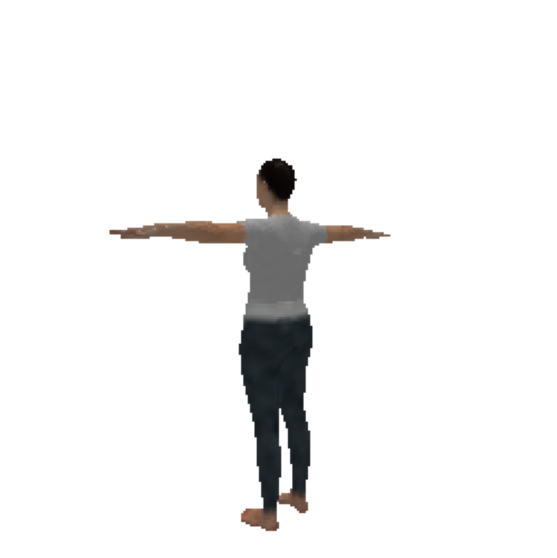

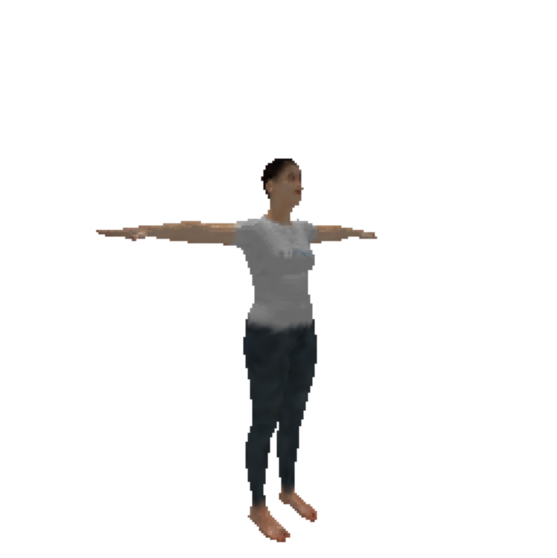

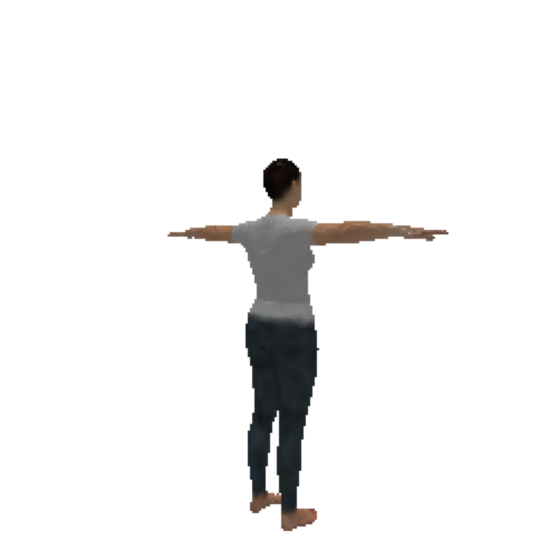

In [14]:
# a quick visualization of the rendered mesh
for test_img_t in test_imgs_t:
  plot_image_t(test_img_t)

## Test: CLIP

In [15]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 209MiB/s]


#### Test: Our Implementation of CLIP Image Preprocessing

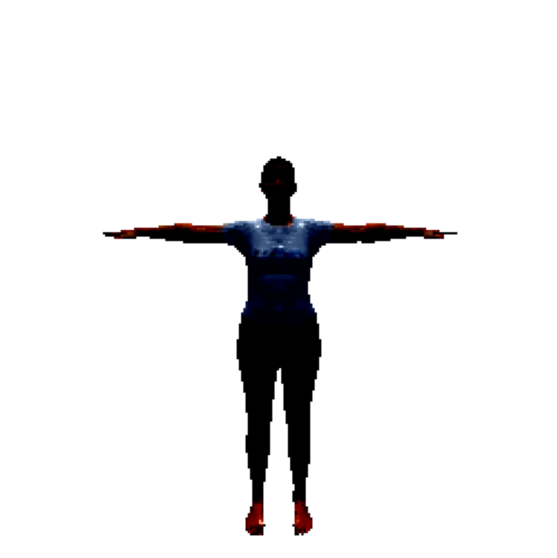

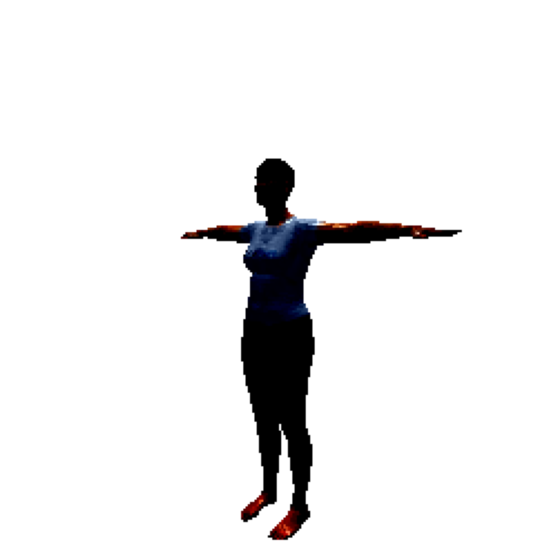

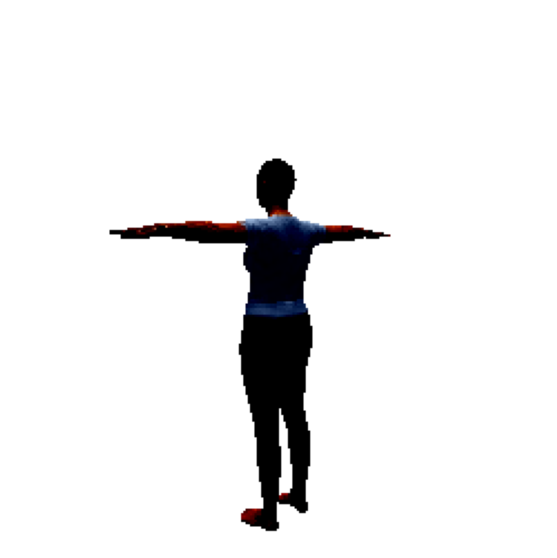

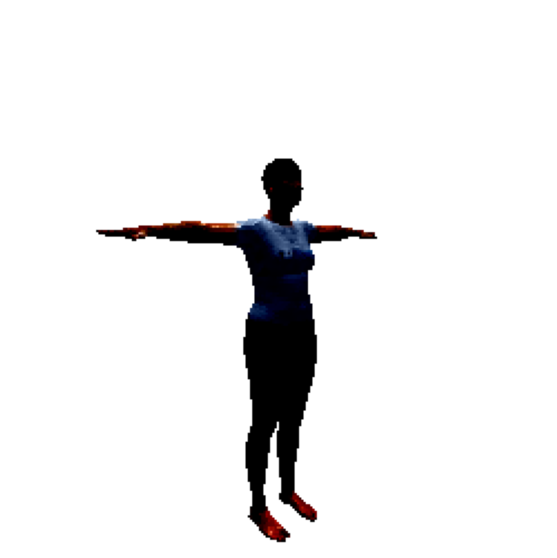

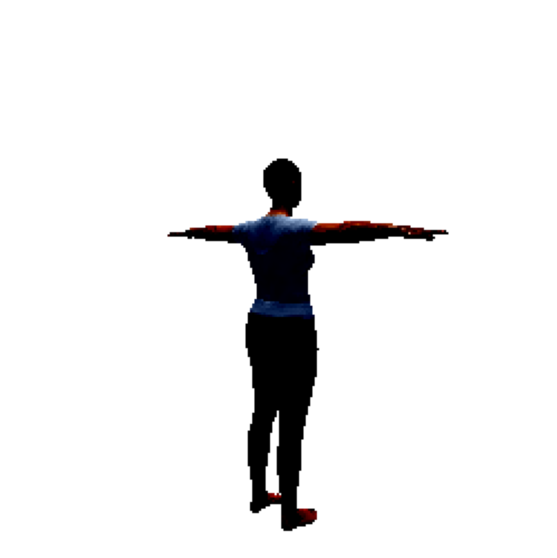

In [17]:
proc_test_imgs_t = torch.permute(clip_model.proc_imgs(test_imgs_t), (0, 2, 3, 1)) # N 3 W H => N W H 3 so 0 1 2 3 => 0 2 3 1
# a quick visualization of the processed images (matplotlib automatically clamps the pixels)
for proc_test_img_t in proc_test_imgs_t:
  plot_image_t(proc_test_img_t)

#### Test: How much does CLIP recognize our mesh and the position it is in ?

In [18]:
# a prompt describing the previous image
pmt_emb = clip_model.pmt_emb("""a brown female person wearing a grey T-shirt and dark pants. The background is white. She is looking upfront and is standing up straight with both feet and hands flat. Both her arms are straight and symmetrically apart from each other while at the shoulders' level.""")
imgs_embs = clip_model.imgs_embs(test_imgs_t)

In [19]:
imgs_embs.shape, pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

In [20]:
# Loss on Average Embedding
img_emb = imgs_embs.mean(axis=0, keepdims=True)
float(cos_dist(img_emb, pmt_emb))

0.65234375

In [21]:
cosine_distances = torch.Tensor([cos_dist(img_emb.unsqueeze(0), pmt_emb) for img_emb in imgs_embs])
cosine_distances

tensor([0.6343, 0.6577, 0.6528, 0.6724, 0.6709])

In [22]:
# Average Loss on Embeddings
float(cosine_distances.mean())

0.6576172113418579

## Prompts

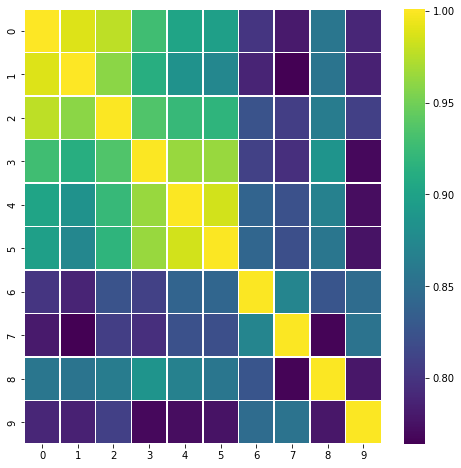

In [28]:
BASE_PROMPT = "a brown person wearing a grey T-shirt and dark pants. The background is white."

POSE_DESCS = [
    # set 1
    "She is looking upfront and is standing up straight with both feet and hands flat. Both her arms are straight and symmetrically apart from each other while at the shoulders' level.",
    "Both her arms are straight and symmetrically apart from each other at the shoulders' level. She is looking upfront and is standing up straight, with both feet and hands flat.",
    # set 2
    "She is looking upfront and is standing up straight with both feet and hands flat. Both her arms are straight above her head.",
    "She is standing up straight on her flat feet. She is looking upfront while grabbing her hips with both hands.",
    "She is standing up on her flat feet and leaning backwards.",
    "She is standing up straight on her flat feet.",
    # set 3
    "She is sitting.",
    "She is running",
    "She is bowing forward with both her hands flat on her thighs and her face facing the ground.",
    # control
    ""
]

TEST_PMTS = [BASE_PROMPT+desc for desc in POSE_DESCS]
N_TEST_PMTS = len(POSE_DESCS)

test_pmts_sim_matrix = np.zeros((N_TEST_PMTS, N_TEST_PMTS))
for i in range(N_TEST_PMTS):
  ref = clip_model.pmt_emb(POSE_DESCS[i])
  for j in range(N_TEST_PMTS):
    test_pmts_sim_matrix[i, j] = cosine_similarity(clip_model.pmt_emb(POSE_DESCS[j]), ref)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(test_pmts_sim_matrix, linewidth=0.5, ax=ax, cmap="viridis")

## MODELS


In [29]:
# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model)
MODELS = [model_context.get_model(prompt=pmt) for pmt in TEST_PMTS]

In [30]:
# sanity check
with torch.no_grad():
  test_pose, test_shape = init_weights(dev)
  test_imgs_embs, test_pmt_emb = MODELS[0](test_pose, test_shape)
test_imgs_embs.shape, test_pmt_emb.shape

(torch.Size([5, 512]), torch.Size([1, 512]))

### Optimization

In [31]:
INNER_PRODUCT_LOSS = lambda imgs_embs, pmt_emb: 1e-3 * (imgs_embs**2).sum(dim=1, keepdim=True) -  imgs_embs @ pmt_emb.T

def run_optimization(model, loss_mode, loss_fn=None, n_passes=1000, gradmask=None):
  # configs
  trackerconfig = TrackerConfig()
  if loss_fn is None: # use default loss function: cosine distance
    optimconfig = OptimConfig(loss_mode=loss_mode)
  else:
    optimconfig = OptimConfig(loss_mode=loss_mode, loss_fn=loss_fn)
  # weights used in optimization
  pose, shape = init_weights(device=dev)
  # optimize with respect to the pose only
  optimenv = OptimEnv(model=model, weights=[pose], config=optimconfig) 
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, trackerconfig=trackerconfig, gradmask=gradmask)
  return result

def best_intermediate_result(result):
  best = {}

  minloss = result["tracked"]["losses"]["loss"].min()
  best_loss_entry = result["tracked"]["losses"].query("loss == @minloss")
 
  best["loss"] = minloss
  best["pass"] = best_loss_entry["pass"].values[0]
  best["pose"] = result["tracked"]["poses"].iloc[best_loss_entry.index[0]]["pose"]
  
  return best

### Results

In [32]:
p2_iploss_aloe = run_optimization(model=MODELS[2], loss_fn=INNER_PRODUCT_LOSS, n_passes=1000, loss_mode="average-loss-on-embeddings")

In [33]:
p2_iploss_loae = run_optimization(model=MODELS[2], loss_fn=INNER_PRODUCT_LOSS, n_passes=1000, loss_mode="loss-on-average-embedding")

In [34]:
p2_cosloss_aloe = run_optimization(model=MODELS[2], n_passes=1000, loss_mode="average-loss-on-embeddings")

In [35]:
p2_cosloss_loae = run_optimization(model=MODELS[2], n_passes=1000, loss_mode="loss-on-average-embedding")

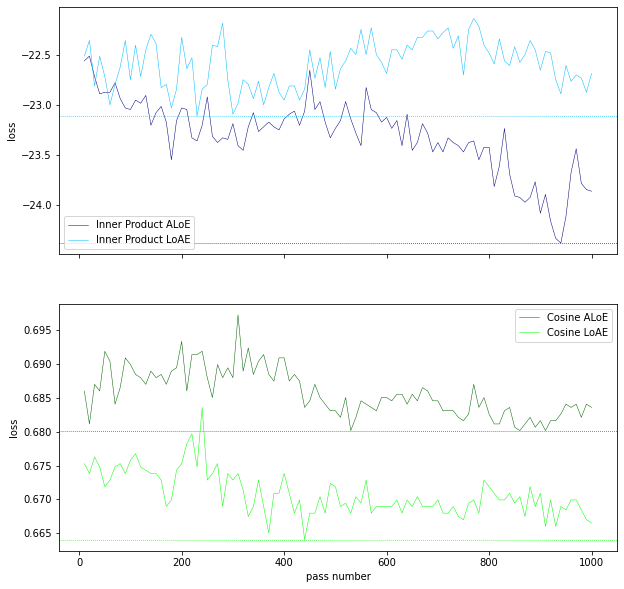

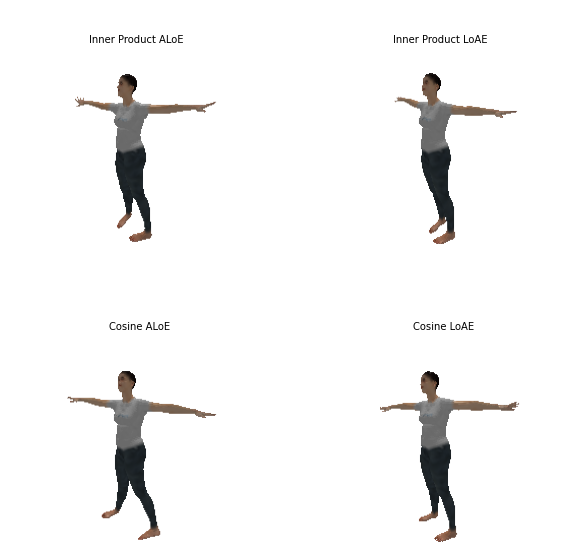

In [51]:
fig1, (loss_ax1, loss_ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig2, pose_axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
pose_axs1, pose_axs2 = pose_axs.reshape(2, 2)

coords = (2.25, 60, 5)
plot_smpl_model = SMPLwrapper(model=None, batchsize=1, txmapping=texture_generator, device=dev) #model=None uses the default model
plot_camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(0.1, 100))
plot_renderer = Renderer(cameras=plot_camera, device=dev)

results_list = [p2_iploss_aloe, p2_iploss_loae]
labels_list  = ["Inner Product ALoE", "Inner Product LoAE"]
colors_list  = ["navy", "deepskyblue"]

for result, label, color, pose_ax in zip(results_list, labels_list, colors_list, pose_axs1):
    best = best_intermediate_result(result)
    # loss
    sns.lineplot(data=result["tracked"]["losses"], x="pass", y="loss", ax=loss_ax1, label=label, color=color, linewidth=0.5)
    loss_ax1.axhline(y=best["loss"], color=color, ls=":", linewidth=0.75)
    loss_ax1.tick_params()
    loss_ax1.set_xlabel("pass number")
    loss_ax1.set_ylabel("loss")
    loss_ax1.legend()
    # pose
    pose, shape = best["pose"].to(dev), torch.ones((1, 10), device=dev)
    mesh = plot_smpl_model.meshes(theta=pose, beta=shape)
    img = plot_renderer.render(mesh)
    pose_ax.imshow(img.cpu().squeeze())
    pose_ax.axis("off")
    pose_ax.text(80, 35, label)
    
results_list = [p2_cosloss_aloe, p2_cosloss_loae]
labels_list = ["Cosine ALoE", "Cosine LoAE"]
colors_list = ["darkgreen", "lime"]

for result, label, color, pose_ax in zip(results_list, labels_list, colors_list, pose_axs2):
    best = best_intermediate_result(result)
    # loss
    sns.lineplot(data=result["tracked"]["losses"], x="pass", y="loss", ax=loss_ax2, label=label, color=color, linewidth=0.5)
    loss_ax2.axhline(y=best["loss"], color=color, ls=":", linewidth=0.75)
    loss_ax2.set_xlabel("pass number")
    loss_ax2.set_ylabel("loss")
    loss_ax2.legend()
    # pose
    pose, shape = best["pose"].to(dev), torch.ones((1, 10), device=dev)
    mesh = plot_smpl_model.meshes(theta=pose, beta=shape)
    img = plot_renderer.render(mesh)
    pose_ax.imshow(img.cpu().squeeze())
    pose_ax.axis("off")
    pose_ax.text(100, 25, label)

In [52]:
MASK_BODY_BOTTOM_HALF_GRAD_UPDATES = torch.zeros((1, 72), device=dev)
MASK_BODY_BOTTOM_HALF_GRAD_UPDATES[:,12*3:] = 1

In [53]:
p2_iploss_aloe = run_optimization(model=MODELS[2], loss_fn=INNER_PRODUCT_LOSS, n_passes=1000, loss_mode="average-loss-on-embeddings",
                                  gradmask=MASK_BODY_BOTTOM_HALF_GRAD_UPDATES)

In [54]:
p2_iploss_loae = run_optimization(model=MODELS[2], loss_fn=INNER_PRODUCT_LOSS, n_passes=1000, loss_mode="loss-on-average-embedding",
                                  gradmask=MASK_BODY_BOTTOM_HALF_GRAD_UPDATES)

In [55]:
p2_cosloss_aloe = run_optimization(model=MODELS[2], n_passes=1000, loss_mode="average-loss-on-embeddings",
                                  gradmask=MASK_BODY_BOTTOM_HALF_GRAD_UPDATES)

In [56]:
p2_cosloss_loae = run_optimization(model=MODELS[2], n_passes=1000, loss_mode="loss-on-average-embedding",
                                   gradmask=MASK_BODY_BOTTOM_HALF_GRAD_UPDATES)

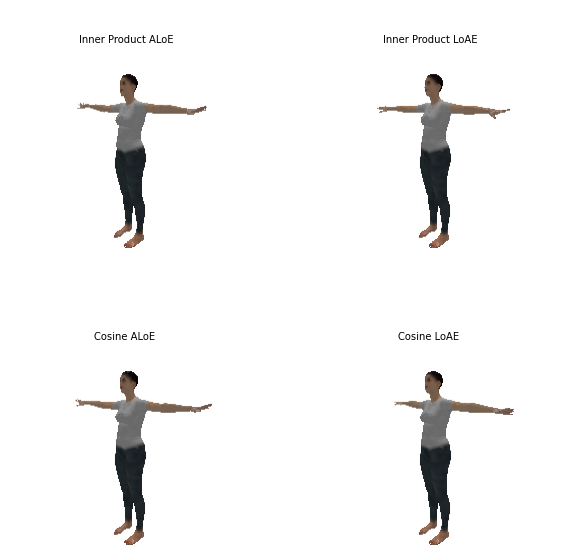

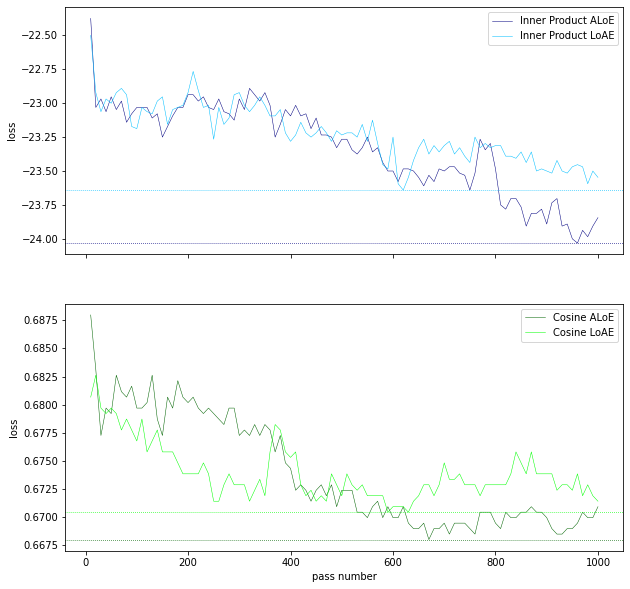

In [59]:
figa, pose_axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
figb, (loss_ax1, loss_ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
pose_axs1, pose_axs2 = pose_axs.reshape(2, 2)

coords = (2.25, 55, 5)
plot_smpl_model = SMPLwrapper(model=None, batchsize=1, txmapping=texture_generator, device=dev) #model=None uses the default model
plot_camera     = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(0.1, 100))
plot_renderer   = Renderer(cameras=plot_camera, device=dev)

results_list = [p2_iploss_aloe, p2_iploss_loae]
labels_list = ["Inner Product ALoE", "Inner Product LoAE"]
colors_list = ["navy", "deepskyblue"]

for result, label, color, pose_ax in zip(results_list, labels_list, colors_list, pose_axs1):
    best = best_intermediate_result(result)
    # loss
    sns.lineplot(data=result["tracked"]["losses"], x="pass", y="loss", ax=loss_ax1, label=label, color=color, linewidth=0.5)
    loss_ax1.axhline(y=best["loss"], color=color, ls=":", linewidth=0.75)
    loss_ax1.set_xlabel("pass number")
    loss_ax1.set_ylabel("loss")
    loss_ax1.legend()
    # pose
    pose, shape = best["pose"].to(dev), torch.ones((1, 10), device=dev)
    mesh = plot_smpl_model.meshes(theta=pose, beta=shape)
    img = plot_renderer.render(mesh)
    pose_ax.imshow(img.cpu().squeeze())
    pose_ax.axis("off")
    pose_ax.text(70, 35, label)
    

results_list = [p2_cosloss_aloe, p2_cosloss_loae]
labels_list = ["Cosine ALoE", "Cosine LoAE"]
colors_list = ["darkgreen", "lime"]

for result, label, color, pose_ax in zip(results_list, labels_list, colors_list, pose_axs2):
    best = best_intermediate_result(result)
    # loss
    sns.lineplot(data=result["tracked"]["losses"], x="pass", y="loss", ax=loss_ax2, label=label, color=color, linewidth=0.5)
    loss_ax2.axhline(y=best["loss"], color=color, ls=":", linewidth=0.75)
    loss_ax2.set_xlabel("pass number")
    loss_ax2.set_ylabel("loss")
    loss_ax2.legend()
    #pose
    pose, shape = best["pose"].to(dev), torch.ones((1, 10), device=dev)
    mesh = plot_smpl_model.meshes(theta=pose, beta=shape)
    img = plot_renderer.render(mesh)
    pose_ax.imshow(img.cpu().squeeze())
    pose_ax.axis("off")
    pose_ax.text(85, 35, label)